In [1]:

from tensorflow.keras import *
from tensorflow.keras.layers import *
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical



from sklearn.utils import resample
from imgaug import augmenters as iaa
import tensorflow as tf
import os
import numpy as np
import cv2
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"]='0'    
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
from os.path import join
train_data_dir = 'resources/faces/nemes/'
import pandas as pd
import seaborn as sns

img_height, img_width = 96,96 # 192, 192 #64,64 #
batch_size = 32
import math
import datetime
from eval_utils import *

%load_ext autoreload
%autoreload 2

c:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


AttributeError: module 'tensorflow.python.util.dispatch' has no attribute 'add_fallback_dispatch_list'

In [7]:
class MyGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, path, batch_size, split = 'train', verbose = 1, do_augment = True, balance = False, limit_per_class = 0):
        self.path           = path
        self.batch_size     = batch_size
        self.split          = split
        self.verbose        = verbose
        self.do_augment     = do_augment
        self.classes        = os.listdir(path)
        self.drop_remaining = True
        self.limit_per_class= limit_per_class
        self.max  = self.countMax()

        self.flip_all =  self.split != 'train' and self.do_augment
       
        if self.split == 'train' and self.do_augment:
            if self.verbose > 1: 
                print("Initializing augmentations")
            self.define_aug()

        self.df = self.folder2pandas(path)
        
        self.train_ratio = 0.6
        self.val_ratio   = 0.2
        self.test_ratio  = 1 - (self.train_ratio + self.val_ratio)

        if balance:
            self.df = self.balanceAndSplit(self.df)
        else:
            self.df = self.splitDf(self.df)
       
        self.img_count = len(self.df)
        if self.flip_all:
            self.img_count*=2
        #SHUFFLE
        self.shuffle()

        if self.verbose > 0:
            print("{} generator Initialized with {} images (b{} -> {})".format(self.split.capitalize(),self.img_count,self.batch_size,len(self)))
        
        if self.verbose > 2:
            print(self.df.head())

    def __len__(self):
        if self.drop_remaining:
            return math.floor(self.img_count / self.batch_size)
        else:
            return math.ceil(self.img_count / self.batch_size)

    def __getitem__(self, idx):
        if self.flip_all:
            ids = range(int(idx*(self.batch_size/2)), int((idx+1)*(self.batch_size/2)))
        else:
            ids = range(int(idx*self.batch_size), int((idx+1)*self.batch_size))


        #batch_df = self.df.loc[ids]
        batch_df = self.df.reindex(index = ids)
        

        x = []
        y = []
        raw_y = []
        for _, row in batch_df.iterrows():
            x.append(self.preprocess(row['y'],row['x']))
            y.append(self.classes.index(row['y']))
            
            if self.flip_all:
                x.append(cv2.flip(self.preprocess(row['y'],row['x']),0))
                y.append(self.classes.index(row['y']))
                raw_y.append(row['y'])
        # for i in self.classes:
        #     if i not in raw_y:
        #         print("Warning! No {} in batch".format(i))
        y = np.array(y, dtype=np.float32)
        x = np.array(x)

        if self.split == 'train' and self.do_augment:  
            try:    
                x = self.augment(x)
            except Exception as e:

                print("ERROR WHILE AUGMENTING ")
                print(batch_df)
                print(e)
                
        x = np.array(x, dtype=np.float32)
        x /= 255
        
        return x, y


    def calculate_class_weights(self):
        total = sum(self.class_counts.values())
        weights = {}

        for i in range(len(self.classes)):
            weights[i]= (1 / self.class_counts[self.classes[i]]) * (total / 2.0)

        return weights
        
    def augment(self, images):
        return self.augmentation_seq(images=images)

    def define_aug(self):
        '''Definition of data augmentation'''

        often       = lambda aug: iaa.Sometimes(0.8, aug)
        sometimes   = lambda aug: iaa.Sometimes(0.5, aug)
        oneinfour   = lambda aug: iaa.Sometimes(0.25, aug)
        rarely      = lambda aug: iaa.Sometimes(0.1, aug)
        hardly_ever = lambda aug: iaa.Sometimes(0.03, aug)
        
        
        seq = iaa.Sequential([
                      
            often(iaa.SomeOf(1,[     
                        iaa.Fliplr(0.5),
                       
            ], random_order=True)),
            
            sometimes(iaa.SomeOf(1, [
                        iaa.Affine(
                            rotate=(-5, 5), 
                            shear=(-5, 5),          #move one side of the image, turning a square into a trapezoid
                            mode="edge"),
                        

            ])),
            
            oneinfour(iaa.SomeOf(3,[
                        iaa.Affine(scale=(0.7, 1.)),  #Zoom
                        iaa.Add((-10, 10)),         #Add a value to all pixels in an image.
                        iaa.Multiply(               #Multiply all pixels in an image with a specific value, thereby making the image darker or brighter.
                        (0.8, 1.2), 
                        per_channel=0.5
                        ),
                        iaa.JpegCompression(compression=(70, 99)),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.04*255)),
                        
            ], random_order=True)),

            rarely(iaa.SomeOf(1,[
                        iaa.ScaleX((0.8, 1.)),
                        iaa.ScaleY((0.8, 1.))
            ], random_order=True)),
            
            hardly_ever(iaa.SomeOf(1,[

                        iaa.TranslateX(px=(-5, 0))
            ], random_order=True)),
      
        ])

        self.augmentation_seq = seq
        
    def on_epoch_end(self):
        '''Performs an action by the end of an epoch.
        '''
        self.shuffle()

    def preprocess(self,label,path):
        
        path = os.path.join(self.path,str(label),str(path))
        #print(path)
        img =  cv2.imread(path)
        img =  cv2.resize(img, (img_height, img_width))
        #print(img.shape)
        return img

    def oneHot(self, label, smoothing = 0.05):
        label = self.classes.index(label)
        label = to_categorical(label,num_classes=len(self.classes))
        return self.smooth_labels(label, smoothing)

    def smooth_labels(self, label, factor):
        label *= (1 - factor)
        label += (factor / len(label))
        return label

    def folder2pandas(self, data_dir):
        df = pd.DataFrame(columns=["x", "y"])
        for category in os.listdir(data_dir):
            i = 0
            for img in os.listdir(join(data_dir,category)):
                df = df.append({
                    "y":    category,
                    "x":    img # join(category,img)
                }, ignore_index = True
                )
                i+=1
                if i == self.limit_per_class:
                    break
        if self.verbose > 1:
            print("Folder explored")
        return df

    def splitDf(self,df):
        df = df.sort_values(by=['x'], ascending=True).reset_index(drop=True)
        train_idxs = df.loc[range(0,int(self.train_ratio*len(df)))]
        val_idxs =   df.loc[range(int(self.train_ratio*len(df)),int(self.train_ratio*len(df))+int(self.val_ratio*len(df)))]
        test_idxs =  df.loc[range(int(self.train_ratio*len(df))+int(self.val_ratio*len(df)),len(df))]

        if self.split == 'train':
            return train_idxs
        elif self.split == 'val':
            return val_idxs
        elif self.split == 'test':
            return test_idxs

    def shuffle(self):
        self.df = self.df.sample(frac=1, random_state = 42).reset_index(drop=True)

    def balanceAndSplit(self, df):        
        if self.split == 'train':
            n_samples = int(self.max*self.train_ratio)
        elif self.split == 'val':
            n_samples = int(self.max*self.val_ratio)
        else:
            n_samples = int(self.max*self.test_ratio)
           
        tmp=[]
        balanced_tmps = []
        for c in self.classes:
            tmp.append(df[df['y']==str(c)])

        #SPLIT
        for df in tmp:
            df = self.splitDf(df)

        for t in tmp:
            tr = resample(t, 
                    replace=True,     
                    n_samples=n_samples,    
                    random_state=69) 
            balanced_tmps.append(tr)
        if self.verbose > 1:      
            print("DataFrame balanced")
        return pd.concat(balanced_tmps)

    def countMax(self):
        max_image_per_label = 0
        class_counts = {}
        for c in os.listdir(self.path):
            l = len(os.listdir(os.path.join(self.path,c)))
            if self.verbose > 1:
                print(c+'-->'+str(l))
            class_counts[c] = l
            if l>max_image_per_label:
                max_image_per_label = l
        if self.verbose > 1:
            print("Groups counted")
        self.class_counts = class_counts

        return max_image_per_label

+-->618
--->564
Groups counted
Folder explored
Train generator Initialized with 38 images (b32 -> 1)
                                          x  y
0  0804f612-f3b7-47fd-ac6c-258362f5feba.jpg  +
1  086a4939-1f2c-4166-bcb1-c4deadda8d86.jpg  +
2  009e6369-5d7c-408b-be62-34d1a12006a7.jpg  +
3  01edab99-1196-489e-ab78-19c8e302e990.jpg  -
4  070af328-1a00-483e-a848-2c64c52f8e7c.jpg  +


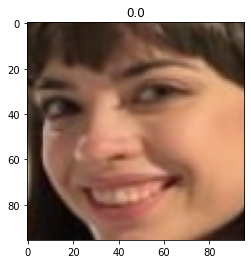

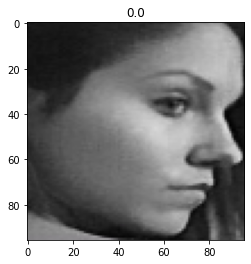

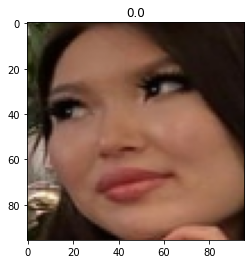

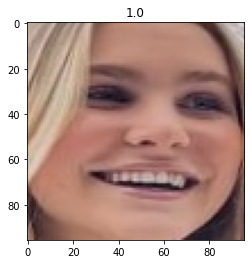

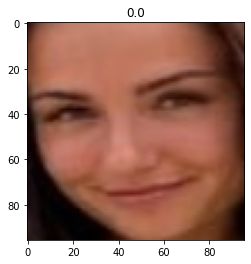

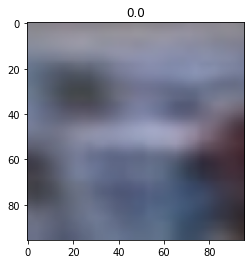

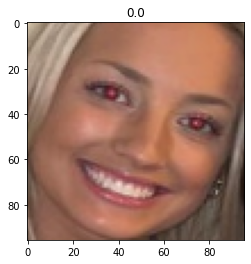

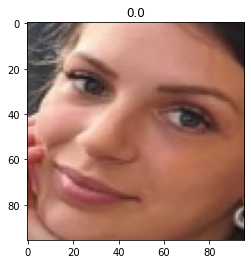

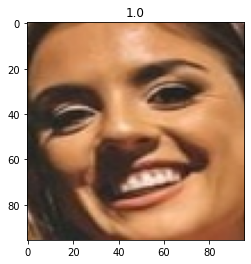

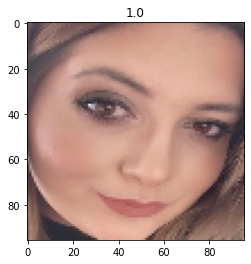

In [8]:
sample_train_data = MyGenerator(train_data_dir, batch_size=batch_size, balance = False, do_augment = False, verbose=3, split='train', limit_per_class = batch_size)
#sample_val_data   = MyGenerator(train_data_dir, batch_size=batch_size, balance = True, verbose=3, split='val', limit_per_class = 1)

imgs, labels = sample_train_data[0]
limit = 10
for i in range(batch_size):
    plt.imshow( cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
    plt.title(labels[i])
    plt.show()
    if i == limit-1:
        break

In [ ]:
def get_model(transfer = False, archi = 'resnet', dropout = 0.0, lr = 1e-4):
    # create model
    model = Sequential()
    if transfer:
        if archi == 'mobilenet':
            model.add(keras.applications.MobileNetV2(include_top=False,
                                                    weights="imagenet",
                                                    input_shape=(img_height, img_width,3),
                        ))
            model.add(keras.layers.Flatten())
        if archi == 'densenet':
            model.add(applications.DenseNet121(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=(img_height, img_width,3),
                pooling=None,
                classes=1000,
                
            ))
            model.add(keras.layers.Flatten())
        if archi == 'resnet':
            model.add(keras.applications.ResNet50(include_top=False,
                                                    weights="imagenet",
                                                    input_shape=(img_height, img_width,3),
                        ))
            model.add(keras.layers.Flatten())
    else:
        model.add( keras.layers.Input(shape=(img_height, img_width,3), name='input_1'))
        if archi == 'mobilenet':
            model.add(keras.applications.MobileNetV2(weights =  None,
                                                    include_top=False,
                                                    input_shape=(img_height, img_width,3)))
            model.add(keras.layers.Flatten())
        if archi == 'densenet':
            model.add(keras.applications.DenseNet121(weights = None,
                                                    include_top=False))
        if archi == 'resnet':
            model.add(keras.applications.ResNet50(include_top=False,
                                                weights=None,
                    ))


    model.add(Dense(256)) #, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(256))#, activation='sigmoid'))
    model.add(BatchNormalization())
    if dropout>0:
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='softmax'))
    
    #focal_loss = keras.losses.BinaryFocalCrossentropy(alpha=0.25, gamma=2)
    binary_loss = keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=binary_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
    model.summary()
    return model

In [10]:
print(train_data[0][0].shape)
print(train_data[0][1].shape)


NameError: name 'train_data' is not defined

In [11]:
model = get_model(transfer = True, archi ='mobilenet', dropout=0.1, lr = 1e-3)

train_data = MyGenerator(train_data_dir, batch_size=batch_size, do_augment = False,balance = True, verbose=0, split='train')
val_data   = MyGenerator(train_data_dir, batch_size=batch_size, do_augment = False, balance = True, verbose=0, split='val')



history = model.fit(train_data,
            batch_size=batch_size,
            epochs = 100,
            validation_data = val_data,
         )

showMe(history)

AttributeError: module 'tensorflow.keras.losses' has no attribute 'BinaryFocalCrossentropy'

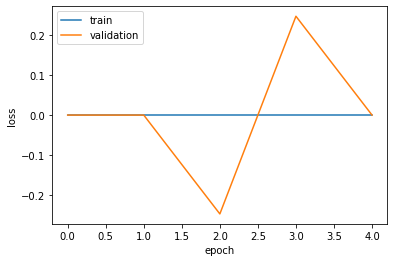

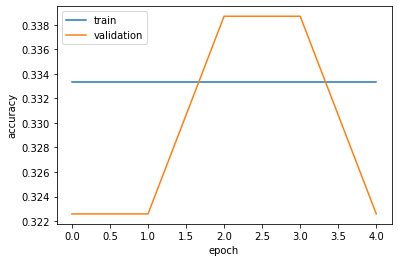

Test accuracy:
Binary: False
Evaluting Axle Category: 100%


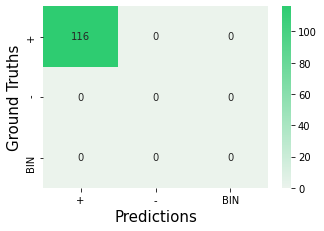


Test accuracy:
Binary: False
Evaluting Axle Category: 100%


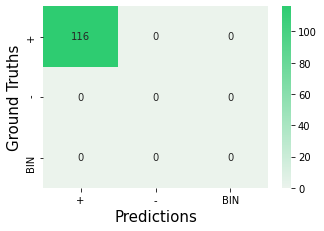

In [21]:
#print("Validation accuracy:")
#MyEval(model,val_data)

test_data   = MyGenerator(train_data_dir, batch_size=batch_size, split='test', verbose = 0)
print("Test accuracy:")
MyEval(model,test_data)
print()
test_data   = MyGenerator(train_data_dir, batch_size=batch_size, split='test', verbose = 0)
print("Test accuracy:")
MyEval(model,test_data)
print()

In [11]:
today = datetime.datetime.now()
version = today.strftime('%Y_%m_%d_%H_%M')
version ='resnet'
model.save('saved_models/'+version)

INFO:tensorflow:Assets written to: saved_models/resnet/assets
